## 1. What Linear Regression training algorithm can you use if you have a training set with millions of features?

**Stochastic Gradient Descent (SGD)**<br>
Scales well with large datasets and millions of features.<br>
Uses little memory, processing one sample at a time.<br>
Supports online learning, updating the model incrementally.<br>
Avoids matrix inversion, which is computationally expensive with many features.<br>

## 2. Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?

**Algorithms that suffer when features have very different scales:**
- Gradient Descent-based algorithms (Linear Regression, Logistic Regression, Neural Networks)
    - The cost function can become elongated, causing slow convergence or getting stuck.
- Support Vector Machines (SVMs)
    - Sensitive to feature scales because it relies on distances; unscaled features can distort the decision boundary.
- K-Nearest Neighbors (KNN) and K-Means Clustering
    - Both rely on distance calculations. Features on larger scales dominate the distance metric, skewing results.

**What to do about it**
- Scale your features using:
    - Standardization (Z-score normalization): Rescales features to have zero mean and unit variance.
    - Min-Max Scaling: Rescales features to a fixed range, typically [0, 1].

## 3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?

No, Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model.<br>

Because,
- The cost function used in Logistic Regression is the log loss (cross-entropy loss), which is a convex function.
- A convex function has one global minimum and no local minima, so Gradient Descent is guaranteed to converge to the global minimum, given:
    - A properly chosen learning rate.
    - The function is well-conditioned (features are scaled).

## 4. Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?

- For convex problems like Linear Regression or Logistic Regression, all Gradient Descent variants (Batch, Stochastic, Mini-batch) will converge to the same global minimum, assuming:
    - A proper learning rate.
    - The learning rate schedule (especially for Stochastic and Mini-batch GD) eventually decays to zero.

- For non-convex problems (like deep neural networks), Gradient Descent variants:
    - May converge to different solutions, since there are multiple local minima and saddle points.
    - Different initialization and random shuffling in SGD and Mini-batch GD can lead to different final models.

## 5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

Overfitting.<br> 

This means the model is learning the training data too well, including its noise, and is failing to generalize to unseen data.<br>

Cause:
- The model is too complex or trained for too long, and it's fitting the training data at the expense of validation performance.

- A less common possibility is a learning rate that is too high, but that usually causes the training/validation error to fluctuate or explode, not steadily increase.

## 6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

No, it is not a good idea.<br>

Mini-batch Gradient Descent introduces noise in the training process because it updates the model using small random subsets of the data.As a result, the validation error can fluctuate from epoch to epoch, even when the overall trend is improving.<br>

Stopping training as soon as the validation error increases could lead to premature stopping, before the model reaches its best performance.

## 7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

Stochastic Gradient Descent (SGD) typically reaches the vicinity of the optimal solution the fastest

- SGD performs updates using one training instance at a time, which makes it very quick per step.

- This randomness helps it escape local minima and explore the loss surface efficiently.

- It can quickly get close to a good solution, though it may not settle precisely at the minimum due to its noisy updates.

Batch Gradient Descent is the algorithm that converges reliably to the minimum of the cost function.

- It uses the entire dataset to compute gradients, so its updates are stable and consistent.

- It converges smoothly to the optimal point (if the learning rate is well chosen).

To help Stochastic Gradient Descent (SGD) or Mini-batch Gradient Descent converge:

- Use a learning rate schedule:

    - Gradually reduce the learning rate over time.

        - This allows the updates to become smaller and more stable as the algorithm approaches the minimum.

    - Use optimization algorithms with momentum or adaptive learning rates.

        - These help smooth out noisy updates and accelerate convergence.

## 8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

Overfitting

typically happens when the polynomial degree is too high, making the model too flexible and capturing noise from the training data

Possible solutions:

Reduce the model complexity, regularization, get more training data

## 9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?

## 10. Why would you want to use:

### • Ridge Regression instead of Linear Regression?

Ridge Regression reduces overfitting by shrinking the model coefficients

### • Lasso instead of Ridge Regression?

Lasso can set some coefficients to zero, effectively performing feature selection

### • Elastic Net instead of Lasso?

Elastic Net combines the benefits of Ridge and Lasso, improving stability when features are correlated

## 11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

Implement two Logistic Regression classifiers rather than a single Softmax Regression classifier.

The reason is that we are dealing with two independent binary classification tasks: one classifier determines whether the picture is outdoor or indoor, and the other determines whether it is daytime or nighttime

## 12. Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn)

In [1]:
import numpy as np
from dataclasses import dataclass

In [2]:
# ------------------------
# Utility functions
# ------------------------
def one_hot(y: np.ndarray, n_classes: int) -> np.ndarray:
    Y = np.zeros((y.size, n_classes), dtype=np.float64)
    Y[np.arange(y.size), y] = 1.0
    return Y

def softmax(Z: np.ndarray) -> np.ndarray:
    Z_shift = Z - Z.max(axis=1, keepdims=True)   # numerical stability
    expZ = np.exp(Z_shift)
    return expZ / expZ.sum(axis=1, keepdims=True)

def cross_entropy(Y_true: np.ndarray, Y_prob: np.ndarray) -> float:
    eps = 1e-12
    return -np.mean(np.sum(Y_true * np.log(Y_prob + eps), axis=1))

def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(y_true == y_pred)

In [3]:
@dataclass
class EarlyStoppingConfig:
    patience: int = 10
    min_delta: float = 0.0  # minimum improvement to reset patience

@dataclass
class TrainingHistory:
    train_loss: list
    val_loss: list
    train_acc: list
    val_acc: list
    best_epoch: int


In [4]:
class SoftmaxRegression:
    def __init__(self, n_features: int, n_classes: int, reg_lambda: float = 0.0, random_state: int | None = None):
        rng = np.random.default_rng(random_state)
        # +1 for bias term
        self.W = rng.normal(scale=0.01, size=(n_features + 1, n_classes))
        self.reg_lambda = reg_lambda

    def _add_bias(self, X: np.ndarray) -> np.ndarray:
        return np.c_[np.ones((X.shape[0], 1)), X]

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        Xb = self._add_bias(X)
        logits = Xb @ self.W
        return softmax(logits)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.argmax(self.predict_proba(X), axis=1)

    def _loss(self, X: np.ndarray, Y: np.ndarray) -> float:
        probs = self.predict_proba(X)
        ce = cross_entropy(Y, probs)
        # do not regularize bias (first row)
        reg = 0.5 * self.reg_lambda * np.sum(self.W[1:] ** 2)
        return ce + reg / X.shape[0]

    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        y_val: np.ndarray,
        lr: float = 0.1,
        n_epochs: int = 1000,
        early_stopping: EarlyStoppingConfig = EarlyStoppingConfig(),
        verbose: bool = False,
    ) -> TrainingHistory:

        n_classes = np.unique(y_train).size
        Y_train = one_hot(y_train, n_classes)
        Y_val   = one_hot(y_val,   n_classes)

        Xb_train = self._add_bias(X_train)
        Xb_val   = self._add_bias(X_val)

        m = X_train.shape[0]

        history = TrainingHistory(train_loss=[], val_loss=[], train_acc=[], val_acc=[], best_epoch=0)

        best_val_loss = np.inf
        best_W = self.W.copy()
        epochs_without_improve = 0

        for epoch in range(1, n_epochs + 1):
            # Forward
            logits = Xb_train @ self.W
            probs = softmax(logits)

            # Gradient (Batch GD)
            grad = (Xb_train.T @ (probs - Y_train)) / m
            grad[1:] += self.reg_lambda * self.W[1:] / m  # regularization

            # Update
            self.W -= lr * grad

            # Metrics
            train_loss = self._loss(X_train, Y_train)
            val_loss   = self._loss(X_val,   Y_val)

            y_pred_train = np.argmax(probs, axis=1)
            y_pred_val   = self.predict(X_val)

            train_acc = accuracy(y_train, y_pred_train)
            val_acc   = accuracy(y_val,   y_pred_val)

            history.train_loss.append(train_loss)
            history.val_loss.append(val_loss)
            history.train_acc.append(train_acc)
            history.val_acc.append(val_acc)

            if verbose and epoch % 50 == 0:
                print(f"Epoch {epoch:4d} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
                      f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}")

            # Early stopping
            if val_loss < best_val_loss - early_stopping.min_delta:
                best_val_loss = val_loss
                best_W = self.W.copy()
                history.best_epoch = epoch
                epochs_without_improve = 0
            else:
                epochs_without_improve += 1
                if epochs_without_improve >= early_stopping.patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch}. Best epoch: {history.best_epoch}")
                    break

        # Rollback
        self.W = best_W
        return history

In [5]:
# Carregar Iris dataset diretamente da UCI
import urllib
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
raw_data = urllib.request.urlopen(url).read().decode("utf-8").strip().split("\n")
data = [line.split(",") for line in raw_data if line.strip() != ""]
X = np.array([list(map(float, row[:4])) for row in data])
labels = [row[4] for row in data]
label_to_int = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_int[label] for label in labels])

# Normalização
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split 80/20
rng = np.random.default_rng(42)
idx = rng.permutation(len(X))
train_size = int(0.8 * len(X))
train_idx, val_idx = idx[:train_size], idx[train_size:]
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]
print(f"Train samples: {len(X_train)}, Validation samples: {len(X_val)}")

Train samples: 120, Validation samples: 30


In [6]:
model = SoftmaxRegression(n_features=X.shape[1], n_classes=len(set(y)), reg_lambda=1e-3, random_state=0)
history = model.fit(
    X_train, y_train,
    X_val, y_val,
    lr=0.5,
    n_epochs=100000,
    early_stopping=EarlyStoppingConfig(patience=50, min_delta=1e-5),
    verbose=True
)
print(f"Best epoch: {history.best_epoch}")
print(f"Final Validation Accuracy: {accuracy(y_val, model.predict(X_val)):.4f}")

Epoch   50 | train_loss=0.2454 val_loss=0.1978 train_acc=0.9333 val_acc=0.9667
Epoch  100 | train_loss=0.1786 val_loss=0.1447 train_acc=0.9500 val_acc=0.9667
Epoch  150 | train_loss=0.1462 val_loss=0.1197 train_acc=0.9583 val_acc=0.9667
Epoch  200 | train_loss=0.1270 val_loss=0.1052 train_acc=0.9750 val_acc=0.9667
Epoch  250 | train_loss=0.1142 val_loss=0.0958 train_acc=0.9750 val_acc=0.9667
Epoch  300 | train_loss=0.1050 val_loss=0.0892 train_acc=0.9750 val_acc=0.9667
Epoch  350 | train_loss=0.0981 val_loss=0.0843 train_acc=0.9750 val_acc=0.9667
Epoch  400 | train_loss=0.0927 val_loss=0.0804 train_acc=0.9750 val_acc=0.9667
Epoch  450 | train_loss=0.0883 val_loss=0.0774 train_acc=0.9750 val_acc=0.9667
Epoch  500 | train_loss=0.0847 val_loss=0.0749 train_acc=0.9750 val_acc=0.9667
Epoch  550 | train_loss=0.0816 val_loss=0.0728 train_acc=0.9750 val_acc=0.9667
Epoch  600 | train_loss=0.0790 val_loss=0.0710 train_acc=0.9750 val_acc=0.9667
Epoch  650 | train_loss=0.0767 val_loss=0.0695 train

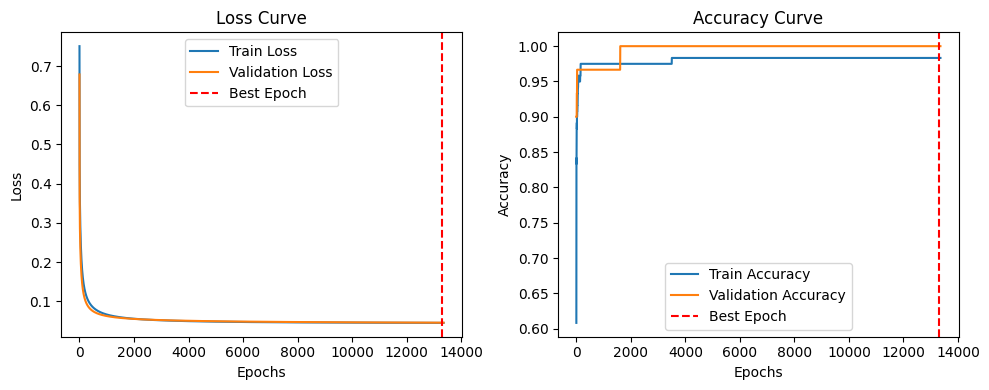

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.train_loss, label="Train Loss")
plt.plot(history.val_loss, label="Validation Loss")
plt.axvline(history.best_epoch, color='red', linestyle='--', label='Best Epoch')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.train_acc, label="Train Accuracy")
plt.plot(history.val_acc, label="Validation Accuracy")
plt.axvline(history.best_epoch, color='red', linestyle='--', label='Best Epoch')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()